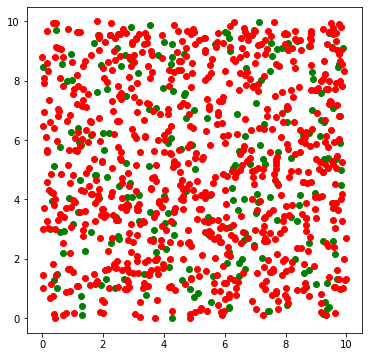

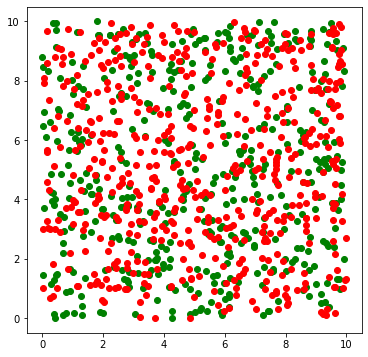

In [215]:
"""Test of the probability mass function for solar model distribution.

Locations are saved as 3-tuple (x, y, b, Y), where b = solar panel installed?


@author: Damian Hoedtke
@date: Jun, 2021

"""

import numpy as np
from numpy import array
import matplotlib.pyplot as plt


# constants
N = 1000
L = 10

def create_initial_distribution():
    np.random.seed(0)
    state = np.random.rand(N, 4) # x, y, b, Y (socioeconomic factors)
    state[:, :2] *= L
    
    state[:, 3] *= 1.0
    
    # probability of solar cell
    p_cell = 0.2
    state[:, 2] = state[:, 2] < p_cell 
    
    return state

def plot_distribution(state):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    cells = state[state[:, 2] == True]
    empty = state[state[:, 2] == False]
    
    ax.scatter(cells[:,0], cells[:,1], color='green')
    ax.scatter(empty[:,0], empty[:,1], color='red')
    
    
def dist2(r1, r2):
    """Caculate shortest distance between r1 and r2 with periodic boundary conditions."""
    # longest possible distance in x / y direction given by L / 2
    dr = abs(r1 - r2)
    
    if dr[0] > L/2:
        dr[0] = L - dr[0]
        
    
    if dr[1] > L/2:
        dr[1] = L - dr[1]
    
    return dr[0] * dr[0] + dr[1] * dr[1]
    
    
def mc_step(state, all_dists):
    
    n_flips = 0
    
    for i, (x, y, b, Y) in enumerate(state):
        
        # calculate probability
        # p_i = nr^-1 sum( beta (rho - 0.5) + 0.5)
        
        rhos = []
        rs = np.arange(0.5, 3.0, 0.5)
        nr = rs.size
        
        p_i = 0.0
    
        for r in rs:
            # calculate density
            
            cells = state[all_dists[i, :] <= r * r][:, 2]
            
            rho = (np.count_nonzero(cells) - int(b)) / cells.size
            rhos.append(rho)
            
            p_i += (2.5 * np.exp(-r) * (rho - Y)) + Y
        
        p_i /= nr
        
        p_i *= 0.8
        p_i += 0.2 * 0.5 # random modification
        
        #print(x, y, b, rhos)
        
        # update solar module
        rand = np.random.rand(1)
        state[i, 2] = p_i > rand
        
        if state[i, 2] != b:
            n_flips += 1
        
    return state, n_flips
    
    

# create initial distribution
state = create_initial_distribution()

# plot initial distribution
plot_distribution(state)


# calculate distances
all_dists = np.zeros((N, N))
for i in range(N-1):
    for j in range(i + 1, N, 1):
        d2 = dist2(state[i, :2], state[j, :2])
        all_dists[i, j] = d2
        all_dists[j, i] = d2
    
n_steps = 700
n_cells, n_flips = [], []
for i in range(n_steps):
    state, flips = mc_step(state, all_dists)
    n_cells.append(np.count_nonzero(state[:, 2]))
    n_flips.append(flips)

plot_distribution(state)

plt.show()

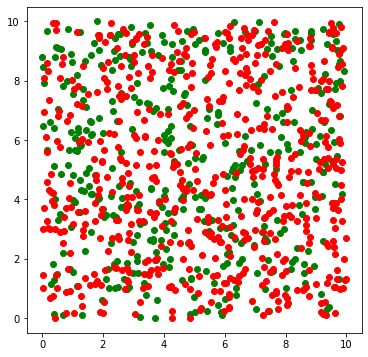

In [216]:
nstate, flips = mc_step(state, all_dists)
plot_distribution(nstate)

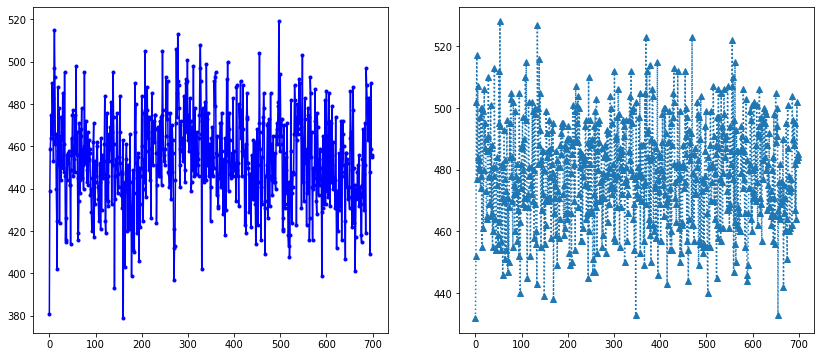

In [217]:
# plot number of cells
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(n_cells, 'b.-')
ax2.plot(n_flips, '^:')

In [218]:
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier as RF

rs = [0.5, 1, 1.5, 2, 2.5, 3]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 2))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    targets = state[:, 2]
    
    X_train, X_test, y_train, y_test = train_test_split(
        data, targets, random_state=0)
    
    model = RF(n_estimators=20).fit(X_train, y_train)
    
    print(model.score(X_test, y_test))
    
    # calculate importances
    imp = permutation_importance(model, X_test, y_test, 
                               n_repeats=30, random_state=0)
    
    importances.append(imp.importances_mean)
    errors.append(imp.importances_std)
    print(imp.importances_mean, imp.importances_std)
    
    previous_rhos = rhos

importances = array(importances)
errors = array(errors)

0.648
[-0.01213333  0.12826667] [0.02184755 0.02876912]
0.612
[-0.02466667  0.07466667] [0.0226058  0.02645919]
0.544
[-0.00653333  0.0076    ] [0.0261989  0.03315177]
0.604
[0.06213333 0.06026667] [0.02969594 0.02523349]
0.56
[0.0368     0.02213333] [0.02524335 0.0249743 ]
0.56
[0.02973333 0.02106667] [0.02969504 0.0243515 ]


<function matplotlib.pyplot.show(close=None, block=None)>

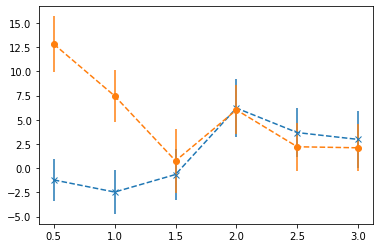

In [219]:
plt.figure()
plt.errorbar(rs, importances[:, 0] * 100, yerr=errors[:, 0] * 100, fmt='x--')
plt.errorbar(rs, importances[:, 1] * 100, yerr=errors[:, 1] * 100, fmt='o--')
plt.show

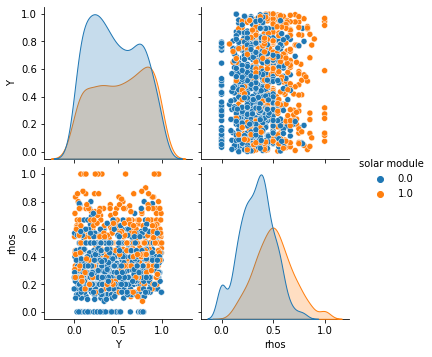

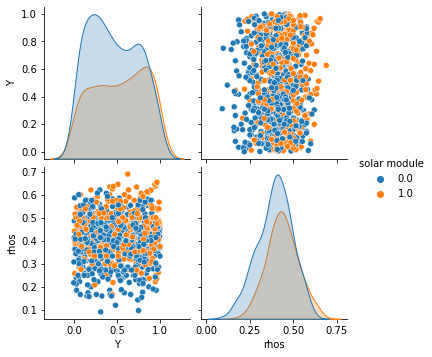

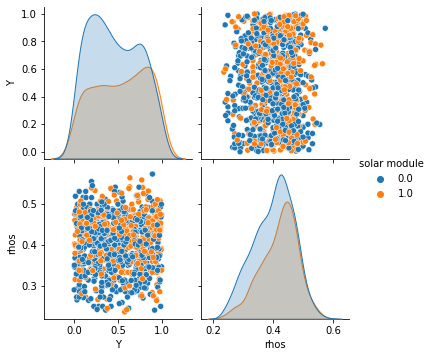

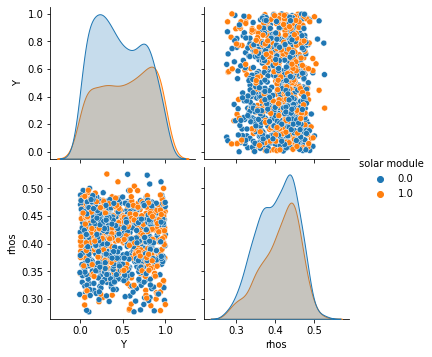

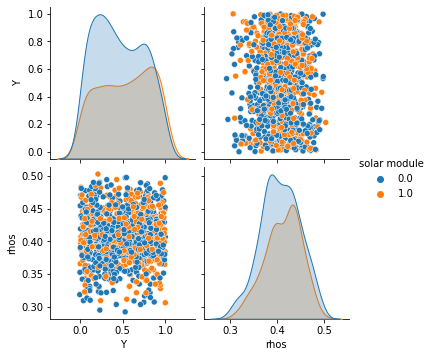

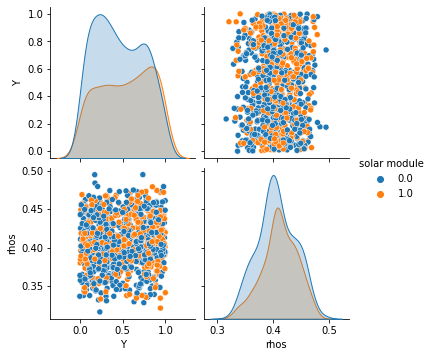

In [225]:
from pandas import DataFrame
from seaborn import pairplot

rs = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]

# for each value of r / r0 calculate feature importances
importances, errors = [], []
previous_rhos = np.zeros(N)
for r in rs:
    
    # calculate density for each location
    rhos = []
    loc_in_range = all_dists <= r * r
    
    for k in range(N):
        cells = state[loc_in_range[k]][:, 2]
        rhos.append(np.count_nonzero(cells) / cells.size)
    
    rhos = array(rhos)
    subtracted_rhos = rhos - previous_rhos
    
    data = np.zeros((N, 3))

    data[:, 0] = state[:, 3] # Y data
    data[:, 1] = subtracted_rhos
                    
    data[:, 2] = state[:, 2]
    
    columns = ["Y", "rhos", "solar module"]
    df = DataFrame(data=data, columns=columns)
    
    pairplot(df, hue='solar module')
    

In [207]:
x

array([0])